In [16]:
import json
import os
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats

### Importing saved metrics JSON files

In [2]:
def import_metrics_json(models_path, run_num):
    """
    Looks in {models_path}/{run_num}/metrics.json and returns the contents as a
    Python dictionary. Returns None if the path does not exist, or the JSON is
    not well-formed.
    """
    path = os.path.join(models_path, str(run_num), "metrics.json")
    if not os.path.exists(path):
        return None
    try:
        with open(path, "r") as f:
            return json.load(f)
    except json.JSONDecodeError:
        print("Metrics JSON at %s is not well-formed" % path)

In [3]:
def get_best_metric_at_best_epoch(models_path, metric_name, reduce_func, compare_func, max_epoch=None):
    """
    Given the path to a set of runs, determines the run with the best metric value,
    for the given `metric_name`. For each run, the function `reduce_func` must take
    the array of all values for that metric and return a (scalar) value FOR EACH
    SUBARRAY/VALUE in the value array to use for comparison. The best metric value
    is determined by `metric_compare_func`, which must take in two arguments, and
    return True if the _first_ one is better. If `max_epoch` is provided, will only
    report everything up to this epoch (1-indexed).
    Returns the number of the run, the (one-indexed) number of the epoch, the value
    associated with that run and epoch, and a dict of all the values used for
    comparison (mapping pair of run number and epoch number to value).
    """
    # Get the metrics, ignoring empty or nonexistent metrics.json files
    metrics = {run_num : import_metrics_json(models_path, run_num) for run_num in os.listdir(models_path)}
    metrics = {key : val for key, val in metrics.items() if val}  # Remove empties
    
    # Get the best value
    best_run, best_epoch, best_val, all_vals = None, None, None, {}
    for run_num in metrics.keys():
        try:
            # Find the best epoch within that run
            best_epoch_in_run, best_val_in_run = None, None
            for i, subarr in enumerate(metrics[run_num][metric_name]["values"]):
                if i == max_epoch:
                    break
                val = reduce_func(subarr)
                if best_val_in_run is None or compare_func(val, best_val_in_run):
                    best_epoch_in_run, best_val_in_run = i + 1, val
            all_vals[(run_num, best_epoch_in_run)] = best_val_in_run
            
            # If the best value in the best epoch of the run is best so far, update
            if best_val is None or compare_func(best_val_in_run, best_val):
                best_run, best_epoch, best_val = run_num, best_epoch_in_run, best_val_in_run
        except Exception as e:
            print(e)
            print("Warning: Was not able to compute values for run %s" % run_num)
            continue
    return best_run, best_epoch, best_val, all_vals

### Profile models

In [4]:
def print_profile_losses(models_path, max_epoch=None):
    """
    Given the path to a condition containing many runs, prints out the best validation
    profile NLL losses for each run, and the set of profile NLL losses for training
    and validation over all epochs, as well as the validation prior loss. If given,
    only consider up to `max_epoch` epochs total; anything afterward would be ignored.
    """
    print("Best profile loss overall:")
    best_run, best_epoch, best_val, all_vals = get_best_metric_at_best_epoch(
        models_path,
        "val_prof_corr_losses",
        lambda values: np.mean(values),
        lambda x, y: x < y,
        max_epoch
    )
    print("\tBest run: %s" % best_run)
    print("\tBest epoch in run: %d" % best_epoch)
    print("\tAssociated value: %s" % best_val)
    
    print("Best epoch in each run:")
    for key in sorted(all_vals.keys(), key=lambda p: int(p[0])):
        print("\tRun %s, epoch %d: %6.2f" % (key[0], key[1], all_vals[key]))
        
    print("All validation profile and prior losses:")
    for key in sorted(all_vals.keys(), key=lambda p: int(p[0])):
        print(key[0])
        metrics = import_metrics_json(models_path, key[0])
        print("\t" + " ".join(["%6.2f" % i for i in np.mean(metrics["train_prof_corr_losses"]["values"], axis=1)[:max_epoch]]))
        print("\t" + " ".join(["%6.2f" % i for i in np.mean(metrics["val_prof_corr_losses"]["values"], axis=1)[:max_epoch]]))
        print("\t" + " ".join(["%6.4f" % i for i in np.mean(metrics["val_att_losses"]["values"], axis=1)[:max_epoch]]))
    return all_vals

In [5]:
profile_models_path = "/users/amtseng/att_priors/models/trained_models/profile/"

In [14]:
noprior_prof_val_losses = print_profile_losses(os.path.join(profile_models_path, "BPNet_keep1_80epochs"))

Best profile loss overall:
	Best run: 25
	Best epoch in run: 62
	Associated value: 149.1433512872387
Best epoch in each run:
	Run 1, epoch 43: 153.81
	Run 2, epoch 71: 152.92
	Run 3, epoch 53: 152.97
	Run 4, epoch 70: 150.00
	Run 5, epoch 44: 151.91
	Run 6, epoch 68: 152.60
	Run 7, epoch 67: 152.45
	Run 8, epoch 38: 152.38
	Run 9, epoch 59: 150.66
	Run 10, epoch 79: 154.18
	Run 11, epoch 66: 151.62
	Run 12, epoch 59: 152.98
	Run 13, epoch 10: 154.99
	Run 14, epoch 59: 152.52
	Run 15, epoch 55: 149.92
	Run 16, epoch 49: 152.91
	Run 17, epoch 57: 153.49
	Run 18, epoch 54: 152.70
	Run 19, epoch 49: 152.40
	Run 20, epoch 38: 152.55
	Run 21, epoch 42: 151.86
	Run 22, epoch 65: 151.60
	Run 23, epoch 50: 150.09
	Run 24, epoch 46: 150.68
	Run 25, epoch 62: 149.14
	Run 26, epoch 41: 152.38
	Run 27, epoch 26: 152.23
	Run 28, epoch 75: 152.17
	Run 29, epoch 38: 151.21
	Run 30, epoch 53: 151.72
All validation profile and prior losses:
1
	316.73 316.01 316.47 316.95 319.67 319.55 318.32 319.65 319.

	319.48 320.07 319.61 319.68 320.25 320.79 320.25 320.93 322.29 319.68 319.26 319.51 319.46 319.01 318.77 318.76 318.26 318.54 317.87 317.66 316.47 314.59 312.20 310.57 309.05 308.31 307.74 307.68 306.67 306.00 305.17 304.29 303.61 302.85 302.24 300.17 296.11 291.50 291.43 288.84 285.49 284.93 282.65 281.33 280.83 279.28 278.97 277.73 276.42 276.38 274.93 273.91 272.96 272.05 274.65 270.65 270.37 269.04 267.65 266.37 265.60 264.69 263.64 263.53 262.67 261.66 261.36 261.05 259.94 259.67 258.99 258.72 257.33 258.90 256.33 255.48 255.79 254.63 254.79 254.15
	155.13 154.91 155.05 155.43 155.54 155.82 155.83 157.46 156.46 154.93 155.24 154.95 155.52 154.95 155.43 155.02 155.04 154.88 154.77 155.20 154.58 155.29 154.83 154.29 154.34 154.51 154.13 153.88 154.02 153.85 154.41 154.06 153.98 153.71 155.08 153.62 153.17 152.38 157.50 153.95 152.90 152.98 153.99 153.28 152.80 153.32 153.81 153.31 154.12 152.70 153.34 153.21 152.77 155.45 152.61 153.42 155.42 154.09 152.49 153.13 153.31 153.77 153.

	319.71 319.72 321.11 321.79 321.58 320.83 322.19 321.18 320.07 319.53 318.69 317.79 317.90 317.60 318.64 318.05 317.13 317.53 316.41 316.91 316.60 316.20 316.30 316.52 316.09 316.13 315.95 315.33 315.53 315.22 314.61 314.82 314.85 314.38 313.89 313.59 313.12 312.70 311.57 310.97 311.22 310.47 309.07 309.14 308.21 308.46 307.67 307.82 306.46 305.78 305.46 303.96 301.21 299.29 297.37 296.22 294.36 292.02 289.58
	155.23 155.20 157.05 156.39 155.19 156.21 155.43 156.28 155.65 155.13 155.48 155.37 155.38 155.55 155.63 155.69 155.10 155.53 154.99 154.97 154.97 155.13 155.14 155.07 155.17 154.95 155.06 155.13 155.12 154.90 155.05 154.92 154.91 154.85 154.70 154.74 155.01 154.41 154.90 154.58 154.71 154.59 154.91 154.65 154.71 154.67 154.82 154.54 154.33 154.12 154.13 154.08 153.96 153.95 154.28 153.78 153.49 153.70 154.43
	0.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0

	318.11 318.46 318.74 319.53 320.92 323.07 320.69 320.97 320.99 318.17 319.81 317.96 316.69 316.00 315.45 314.69 314.40 313.60 313.61 312.55 312.05 310.63 310.52 308.68 310.39 308.51 307.19 306.38 304.98 304.98 304.84 303.60 302.81 301.85 301.24 299.51 297.08 294.73 289.46 288.13 285.67 283.44 283.97 281.83 280.85 280.16 278.46 276.98 276.39 275.61 274.40 274.66 273.97 271.31 270.14 269.67 267.51 266.79 266.40 265.07 264.33 264.50 261.58 261.01 259.91 261.51 259.58 258.12 259.76 257.49 256.66 255.81 254.45 254.58 256.16 256.69 253.38 254.90 252.20 251.69
	154.70 155.01 154.84 156.16 158.09 155.23 156.51 161.01 155.02 155.06 156.52 154.83 154.91 154.63 154.62 154.64 154.29 155.09 153.99 156.39 154.24 154.08 154.11 154.09 154.61 154.43 154.36 154.43 153.96 154.10 153.82 153.84 154.35 154.11 153.74 153.49 154.14 153.60 152.71 152.65 152.38 152.43 154.09 153.27 152.71 153.40 152.62 152.43 152.50 152.42 152.60 154.72 152.62 154.04 153.42 153.19 152.76 152.92 153.19 153.48 153.81 153.17 153.

In [6]:
prior_prof_val_losses = print_profile_losses(os.path.join(profile_models_path, "BPNet_prior_keep1_80epochs"))

Best profile loss overall:
	Best run: 9
	Best epoch in run: 54
	Associated value: 151.31487385746047
Best epoch in each run:
	Run 1, epoch 56: 153.28
	Run 2, epoch 80: 153.93
	Run 3, epoch 53: 153.23
	Run 4, epoch 50: 153.16
	Run 5, epoch 44: 152.09
	Run 6, epoch 53: 151.95
	Run 7, epoch 79: 153.82
	Run 8, epoch 79: 151.85
	Run 9, epoch 54: 151.31
	Run 10, epoch 14: 154.15
All validation profile and prior losses:
1
	320.60 320.87 322.25 322.44 323.29 324.38 328.29 324.84 322.20 320.40 320.19 319.81 319.80 319.67 319.56 319.49 319.39 319.18 319.08 319.20 319.30 319.14 319.12 319.17 319.18 318.79 318.89 318.95 318.94 319.01 318.89 318.84 318.86 318.80 318.66 318.67 318.86 318.81 318.76 318.60 318.76 318.48 318.42 318.25 318.18 318.09 317.52 317.21 316.29 315.63 314.98 314.40 314.16 313.71 311.58 309.51 305.39
	154.94 155.45 155.79 155.84 158.07 156.09 159.27 156.21 156.10 155.48 154.79 155.00 155.06 155.15 155.04 155.01 155.05 155.10 154.93 154.84 154.78 154.67 154.84 154.81 154.78 154.7

	322.39 322.71 322.81 323.14 322.75 323.05 323.57 322.85 322.95 321.73 321.87 321.24 321.48 321.18 321.04 321.05 321.07 321.00 320.77 320.75 320.80 320.51 320.61 320.16 320.46 320.17 320.15 319.30 319.01 318.94 318.16 318.33 317.71 317.43 317.13 316.92 315.88 314.87 315.23 314.17 313.72 312.80 312.49 312.85 312.51 311.54 310.92 311.03 311.76 310.38 309.99 309.75 310.06 308.68 305.43 301.29 299.46 294.59 294.72 291.55 288.70 288.06 285.91 283.92 281.80 281.80 280.37 278.85 276.46 277.90 275.70 272.77 271.01 270.95 270.12 268.27 267.77 266.48 265.50 263.88
	155.07 155.20 155.36 155.71 155.38 156.52 155.43 156.41 155.26 155.13 155.09 154.87 154.99 155.00 155.03 155.29 154.93 154.91 155.11 155.02 155.22 155.01 155.04 155.29 154.92 154.93 154.77 154.75 154.80 154.91 154.98 154.60 154.88 154.79 154.66 154.84 154.61 154.46 154.56 154.30 154.78 154.82 154.96 154.88 155.13 154.89 154.36 154.67 154.59 154.52 155.46 154.34 155.11 153.93 153.84 153.62 153.48 155.63 154.45 155.18 154.27 153.08 152.

Mean without priors: 152.101766
Mean with priors: 152.876148
One-sided t-test p: 0.047597


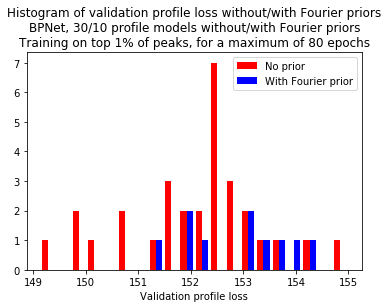

In [10]:
bin_num = 20
plt.figure()
plt.hist(
    [np.array(list(noprior_prof_val_losses.values())), np.array(list(prior_prof_val_losses.values()))],
    bin_num, histtype="bar",
    label=["No prior", "With Fourier prior"], color=["red", "blue"])
title = "Histogram of validation profile loss without/with Fourier priors"
title += "\nBPNet, %d/%d profile models without/with Fourier priors" % (len(noprior_prof_val_losses), len(prior_prof_val_losses))
title += "\nTraining on top 1% of peaks, for a maximum of 80 epochs"
plt.title(title)
plt.xlabel("Validation profile loss")
plt.legend()

np_vals, p_vals = np.array(list(noprior_prof_val_losses.values())), np.array(list(prior_prof_val_losses.values()))
t, p = scipy.stats.ttest_ind(np_vals, p_vals)
print("Mean without priors: %f" % np.mean(np_vals))
print("Mean with priors: %f" % np.mean(p_vals))
print("One-sided t-test p: %f" % (p / 2))

### Binary models

In [4]:
def print_binary_losses(models_path, max_epoch=None):
    """
    Given the path to a condition containing many runs, prints out the best validation
    losses for each run, and the set of losses for training and validation over all
    epochs, as well as the validation prior loss. If given, only consider up to
    `max_epoch` epochs total; anything afterward would be ignored.
    """
    print("Best validation loss overall:")
    best_run, best_epoch, best_val, all_vals = get_best_metric_at_best_epoch(
        models_path,
        "val_corr_losses",
        lambda values: np.mean(values),
        lambda x, y: x < y,
        max_epoch
    )
    print("\tBest run: %s" % best_run)
    print("\tBest epoch in run: %d" % best_epoch)
    print("\tAssociated value: %s" % best_val)
    
    print("Best epoch in each run:")
    for key in sorted(all_vals.keys(), key=lambda p: int(p[0])):
        print("\tRun %s, epoch %d: %6.3f" % (key[0], key[1], all_vals[key]))
        
    print("All validation profile and prior losses:")
    for key in sorted(all_vals.keys(), key=lambda p: int(p[0])):
        print(key[0])
        metrics = import_metrics_json(models_path, key[0])
        print("\t" + " ".join(["%6.3f" % i for i in np.mean(metrics["train_corr_losses"]["values"], axis=1)[:max_epoch]]))
        print("\t" + " ".join(["%6.3f" % i for i in np.mean(metrics["val_corr_losses"]["values"], axis=1)[:max_epoch]]))
        print("\t" + " ".join(["%6.3f" % i for i in np.mean(metrics["val_att_losses"]["values"], axis=1)[:max_epoch]]))
    return all_vals

In [5]:
binary_models_path = "/users/amtseng/att_priors/models/trained_models/binary/"

In [17]:
noprior_bin_val_losses = print_binary_losses(os.path.join(binary_models_path, "K562"))

Best validation loss overall:
	Best run: 18
	Best epoch in run: 1
	Associated value: 0.24132131622769895
Best epoch in each run:
	Run 1, epoch 1:  0.248
	Run 3, epoch 1:  0.255
	Run 4, epoch 1:  0.252
	Run 5, epoch 1:  0.254
	Run 7, epoch 1:  0.242
	Run 8, epoch 1:  0.254
	Run 9, epoch 1:  0.253
	Run 11, epoch 1:  0.251
	Run 12, epoch 1:  0.249
	Run 13, epoch 1:  0.253
	Run 14, epoch 1:  0.245
	Run 15, epoch 1:  0.246
	Run 16, epoch 1:  0.265
	Run 18, epoch 1:  0.241
	Run 19, epoch 1:  0.247
	Run 20, epoch 1:  0.254
	Run 23, epoch 1:  0.248
	Run 24, epoch 1:  0.253
	Run 25, epoch 1:  0.249
	Run 28, epoch 1:  0.249
	Run 29, epoch 1:  0.249
	Run 30, epoch 1:  0.250
All validation profile and prior losses:
1
	 0.215  0.142  0.109  0.089  0.078
	 0.248  0.281  0.331  0.372  0.400
	 0.000  0.000  0.000  0.000  0.000
3
	 0.219  0.143  0.109  0.090  0.078
	 0.255  0.314  0.346  0.384  0.423
	 0.000  0.000  0.000  0.000  0.000
4
	 0.224  0.146  0.113  0.092  0.079
	 0.252  0.282  0.311  0.384 

In [18]:
prior_bin_val_losses = print_binary_losses(os.path.join(binary_models_path, "K562_prior"))

Best validation loss overall:
	Best run: 9
	Best epoch in run: 8
	Associated value: 0.2318139820654168
Best epoch in each run:
	Run 1, epoch 3:  0.262
	Run 2, epoch 4:  0.255
	Run 3, epoch 7:  0.244
	Run 4, epoch 7:  0.243
	Run 5, epoch 3:  0.248
	Run 6, epoch 7:  0.236
	Run 7, epoch 7:  0.241
	Run 8, epoch 5:  0.245
	Run 9, epoch 8:  0.232
	Run 10, epoch 5:  0.238
	Run 11, epoch 3:  0.235
	Run 12, epoch 6:  0.232
	Run 13, epoch 5:  0.245
	Run 14, epoch 5:  0.245
	Run 15, epoch 3:  0.238
	Run 16, epoch 4:  0.244
	Run 18, epoch 4:  0.244
	Run 19, epoch 5:  0.244
	Run 20, epoch 3:  0.240
	Run 21, epoch 6:  0.246
	Run 22, epoch 5:  0.238
	Run 23, epoch 5:  0.244
	Run 24, epoch 8:  0.245
	Run 25, epoch 6:  0.235
	Run 27, epoch 7:  0.243
All validation profile and prior losses:
1
	 0.286  0.241  0.220  0.202  0.184  0.170  0.146  0.153  0.125  0.119
	 0.281  0.277  0.262  0.267  0.268  0.337  0.302  0.319  0.329  0.340
	 0.060  0.056  0.050  0.052  0.047  0.063  0.039  0.038  0.035  0.035
2

Mean without priors: 0.250347
Mean with priors: 0.242507
One-sided t-test p: 0.000025


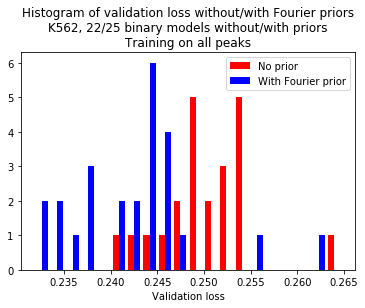

In [19]:
bin_num = 20
plt.figure()
plt.hist(
    [np.array(list(noprior_bin_val_losses.values())), np.array(list(prior_bin_val_losses.values()))],
    bin_num, histtype="bar",
    label=["No prior", "With Fourier prior"], color=["red", "blue"])
title = "Histogram of validation loss without/with Fourier priors"
title += "\nK562, %d/%d binary models without/with priors" % (len(noprior_bin_val_losses), len(prior_bin_val_losses))
title += "\nTraining on all peaks"
plt.title(title)
plt.xlabel("Validation loss")
plt.legend()

np_vals, p_vals = np.array(list(noprior_bin_val_losses.values())), np.array(list(prior_bin_val_losses.values()))
t, p = scipy.stats.ttest_ind(np_vals, p_vals)
print("Mean without priors: %f" % np.mean(np_vals))
print("Mean with priors: %f" % np.mean(p_vals))
print("One-sided t-test p: %f" % (p / 2))